In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpld3
from scipy.interpolate import interp1d
from nonlinear import hammersteinModel as hammerstein
#from nonlinear import hammersteinLinearApproximation as linearHammer

## System
Define the system and calculate input and output signals

In [12]:
nsamples = 2**12
noiselevel = 0.25

def m(u):
    # return (1-np.exp(-np.abs(u)))*np.sign(u)
    return (u**2+0.5*u**3)/1.5
    # return u**2
def lbda(n):
    with np.errstate(divide='ignore',invalid='ignore'):
        return np.select([n<0,n==25,n<1000],[0.,0.7,1.0/1.05**n],0)

inputsignal = 2*np.random.rand(nsamples)-1
ir = lbda(np.arange(1000))*(2*np.random.rand(1000)-1)
ir[0]=1

trueSystem = hammerstein()
trueSystem.nonlinearity = m
trueSystem.impulseResponse = ir
outputsignal = trueSystem(inputsignal)
    
noiseout = outputsignal + noiselevel*np.max(np.abs(outputsignal))*(2*np.random.rand(nsamples)-1)
scale = np.max(np.abs(noiseout))
noiseout = noiseout/scale


## Non-linear approximation
Define parameters for the approximation of the non-linearity, and perform the calculations.
This part uses the raw input and output algorithms, with a rectangular kernel $K$.

For non-linearities which $m(0)=0$ we can shift the approximation by $\mu(0)$ This will be true for all acoustic non-linearities.

In [3]:
rectangularSystem = hammerstein(kernel='rectangular',npoints=2**12)
rectangularSystem.approximateNonlinearity(inputsignal,noiseout)
legendreSystem = hammerstein(kernel='legendre',npoints=2**12)
legendreSystem.setOrthogonalBasis('legendre')
legendreSystem.approximateNonlinearity(inputsignal,noiseout)
legendreSystem.orthogonalSeriesExpansion(inputsignal,outputsignal)


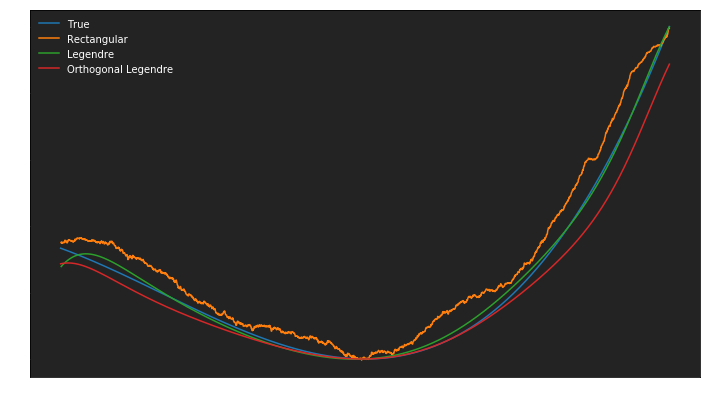

In [4]:
x=np.linspace(-1,1,1e3)
#plt.scatter(inputsignal,noiseout,marker='.',facecolor='none',edgecolor='gray',alpha=0.5)
plt.plot(x,m(x),label='True')
plt.plot(x,rectangularSystem.nonlinearity(x),label='Rectangular')
plt.plot(x,legendreSystem.nonlinearity(x),label='Legendre')
plt.plot(x,legendreSystem.orthogonalApproximation(x),label='Orthogonal Legendre')
plt.legend()
plt.show()

## Linear system approximation
Approximate the parameter $\kappa$, proportional to the dynamic impulse response of the linear system.
This part uses the proposed algorithm without compensating for the non-linear system.

$\kappa$ can be normalized by dividing by the first element. This will give a better appoximation if the original impulse response has unity gain for the first element.

In [5]:
rectangularSystem.approximateLinearity(inputsignal,outputsignal)
legendreSystem.approximateLinearity(inputsignal,outputsignal)


In [6]:
db = lambda x:20*np.log10(np.abs(x))
plt.plot(db(ir[:256]),label='True')
plt.plot(db(rectangularSystem.impulseResponse),label='Rectangular')
plt.plot(db(legendreSystem.impulseResponse),label='Legendre')
plt.legend()
#plt.show()
mpld3.display()

In [17]:
x=np.linspace(-1,1,1e3)
db = lambda x:20*np.log10(np.abs(x))
refiningSystem = hammerstein('rectangular',irlen=60)

plt.subplot(1,2,1)
plt.plot(x,m(x),label='True')
plt.subplot(1,2,2)
plt.plot(db(ir[:60]),label='True')


refiningSystem.approximateNonlinearity(inputsignal,noiseout)
refiningSystem.approximateLinearity(inputsignal,noiseout)
plt.subplot(1,2,1)
plt.plot(x,refiningSystem.nonlinearity(x),label='First approx')
plt.subplot(1,2,2)
plt.plot(db(refiningSystem.impulseResponse),label='First approx')

inputsignal = 2*np.random.rand(nsamples)-1
outputsignal = trueSystem(inputsignal)
noiseout = outputsignal + noiselevel*np.max(np.abs(outputsignal))*(2*np.random.rand(nsamples)-1)
refiningSystem.refineModel(inputsignal,noiseout)
plt.subplot(1,2,1)
plt.plot(x,refiningSystem.nonlinearity(x),label='Second approx')
plt.subplot(1,2,2)
plt.plot(db(refiningSystem.impulseResponse),label='Second approx')

inputsignal = 2*np.random.rand(nsamples)-1
outputsignal = trueSystem(inputsignal)
noiseout = outputsignal + noiselevel*np.max(np.abs(outputsignal))*(2*np.random.rand(nsamples)-1)
refiningSystem.refineModel(inputsignal,noiseout)
plt.subplot(1,2,1)
plt.plot(x,refiningSystem.nonlinearity(x),label='Third approx')
plt.subplot(1,2,2)
plt.plot(db(refiningSystem.impulseResponse),label='Third approx')

inputsignal = 2*np.random.rand(nsamples)-1
outputsignal = trueSystem(inputsignal)
noiseout = outputsignal + noiselevel*np.max(np.abs(outputsignal))*(2*np.random.rand(nsamples)-1)
refiningSystem.refineModel(inputsignal,noiseout)
inputsignal = 2*np.random.rand(nsamples)-1
outputsignal = trueSystem(inputsignal)
noiseout = outputsignal + noiselevel*np.max(np.abs(outputsignal))*(2*np.random.rand(nsamples)-1)
refiningSystem.refineModel(inputsignal,noiseout)
inputsignal = 2*np.random.rand(nsamples)-1
outputsignal = trueSystem(inputsignal)
noiseout = outputsignal + noiselevel*np.max(np.abs(outputsignal))*(2*np.random.rand(nsamples)-1)
refiningSystem.refineModel(inputsignal,noiseout)

plt.subplot(1,2,1)
plt.plot(x,refiningSystem.nonlinearity(x),label='Sixth approx')
plt.subplot(1,2,2)
plt.plot(db(refiningSystem.impulseResponse),label='Sixth approx')

plt.subplot(1,2,1)
plt.legend()
plt.subplot(1,2,2)
plt.legend()
mpld3.display()


In [127]:
%qtconsole